In [1]:
# Illustrate parity check code using a directed graphical model
# Authors: murphyk@, Drishtii@
# Based on
# https://github.com/probml/pmtk3/blob/master/demos/errorCorrectingCodeDemo.m


try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

import probml_utils.pgmpy_utils as pgm

try:
    from pgmpy.models import BayesianModel
except ModuleNotFoundError:
    %pip install -qq pgmpy
    from pgmpy.models import BayesianModel

from pgmpy.factors.discrete import TabularCPD
import numpy as np
import matplotlib.pyplot as plt

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'X1': array([0.34693878, 0.65306122]), 'X2': array([0.65306122, 0.34693878]), 'X3': array([0.65306122, 0.34693878])}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/patel_karm/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


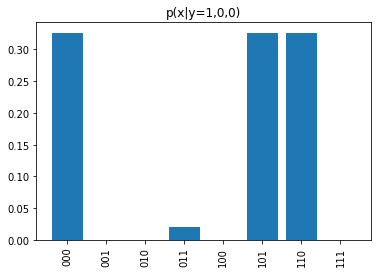

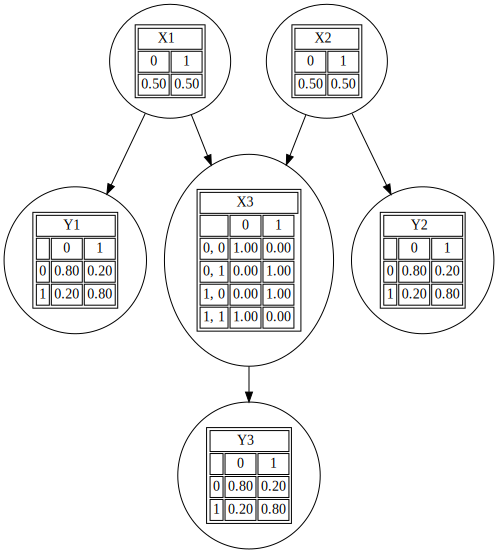

In [2]:
# DAG structure
model = BayesianModel([("X2", "X3"), ("X1", "X3"), ("X1", "Y1"), ("X2", "Y2"), ("X3", "Y3")])

# Defining individual CPDs.
CPDs = {}
CPDs["X1"] = TabularCPD(variable="X1", variable_card=2, values=[[0.5], [0.5]])

CPDs["X2"] = TabularCPD(variable="X2", variable_card=2, values=[[0.5], [0.5]])

CPDs["X3"] = TabularCPD(
    variable="X3", variable_card=2, values=[[1, 0, 0, 1], [0, 1, 1, 0]], evidence=["X1", "X2"], evidence_card=[2, 2]
)

noise = 0.2
for i in range(3):
    parent = "X{}".format(i + 1)
    child = "Y{}".format(i + 1)
    CPDs[child] = TabularCPD(
        variable=child,
        variable_card=2,
        values=[[1 - noise, noise], [noise, 1 - noise]],
        evidence=[parent],
        evidence_card=[2],
    )

# Make model
for cpd in CPDs.values():
    model.add_cpds(cpd)
model.check_model()

from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

# Inference
evidence = {"Y1": 1, "Y2": 0, "Y3": 0}
marginals = {}
for i in range(3):
    name = "X{}".format(i + 1)
    post = infer.query([name], evidence=evidence).values
    marginals[name] = post
print(marginals)

joint = infer.query(["X1", "X2", "X3"], evidence=evidence).values
J = joint.reshape(8)
fig, ax = plt.subplots()
plt.title("p(x|y=1,0,0)")
y = ["0", "000", "001", "010", "011", "100", "101", "110", "111"]
ax.bar(x=np.arange(8), height=J)
ax.set_xticklabels(y, rotation=90)
pml.savefig("error_correcting.pdf")
plt.show()

pgm.visualize_model(model)